In [ ]:
!pip install roboflow

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Kidney-Disease-Detection-3.zip

In [4]:


from roboflow import Roboflow
rf = Roboflow(api_key="C2xK1asLje62aqygd0nb")
project = rf.workspace("detection-z61nb").project("kidney-disease-detection-tssej")
version = project.version(3)
dataset = version.download("yolov8-obb")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!pip install ultralytics


In [6]:
import os
print(os.path.exists('./Kidney-Disease-Detection-3/data.yaml'))


True


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [1]:
import numpy as np
import cv2

def window_ct(img, WL=40, WW=350):
    """
    Apply soft tissue windowing to CT image.
    img: uint8 or float grayscale image
    """
    img = img.astype(np.float32)

    # If image is 0–255, convert to HU-like range
    if img.max() <= 255:
        img = img / 255.0  # 0–1
        img = img * 1500 - 1000  # map to HU-like range (approx)

    lower = WL - (WW / 2)
    upper = WL + (WW / 2)
    img = np.clip(img, lower, upper)

    # normalize to 0-255
    img = (img - lower) / (upper - lower)
    img = (img * 255).astype(np.uint8)

    return img


def preprocess_ct(img):
    """
    Full pipeline for CT preprocessing before YOLO:
    1. Convert to grayscale
    2. Apply soft tissue window
    3. Resize to YOLO input size
    """
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = window_ct(img)

    # convert back to 3-channel because YOLO needs 3 channels
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    return img


In [2]:
from ultralytics import YOLO
import cv2


model = YOLO("yolov8n.pt")

def preprocess_dataset(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = preprocess_ct(img)
    return img


In [10]:
# Train on your Roboflow dataset

model.train(
    data="/content/Kidney-Disease-Detection-3/data.yaml",
    imgsz=640,
    epochs=80,
    patience=20,
    batch=16,
    hsv_h=0.015,
    hsv_s=0.6,
    hsv_v=0.4,
    scale=0.4,
    degrees=5,
    translate=0.1,
    fliplr=0.5,
    flipud=0.1,
    mosaic=1.0,
    mixup=0.2,
)



Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Kidney-Disease-Detection-3/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plot

KeyboardInterrupt: 

# model.save('kidney_yolov8_model.pt')

In [ ]:
model.save('kidney_yolov8_model.pt')

In [ ]:
model=YOLO('kidney_yolov8_model.pt')

In [15]:
metrics = model.val(data="/content/Kidney-Disease-Detection-3/data.yaml", save_json=True, plots=True)
print(metrics)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 13,260 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 164.3±310.0 MB/s, size: 30.5 KB)
val: Scanning /content/Kidney-Disease-Detection-3/valid/labels.cache... 318 images, 34 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 318/318 573.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 4.1it/s 4.8s
                   all        318        284      0.895      0.884      0.903      0.526
                NORMAL         37         37      0.982          1      0.995      0.722
                 STONE         39         39       0.91      0.718       0.85      0.273
                 TUMOR        179        179      0.835      0.827      0.784      0.282
                 cysts         29         29      0.852       0.99      0.983      0.825
Speed: 1.3ms preprocess,

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import cv2

def get_img(img_path):
    img = cv2.imread(img_path)
    img = preprocess_ct(img)
    return img


0: 640x640 1 NORMAL, 352.4ms
Speed: 103.2ms preprocess, 352.4ms inference, 27.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\ramka\datascience-nlp\34-kidneyProject\runs\detect\predict


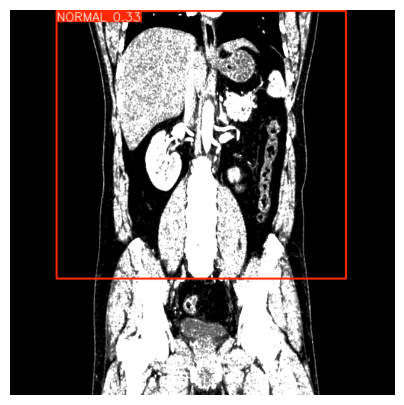

In [6]:
results = model.predict(source=get_img("./Kidney-Disease-Detection-3/test/images/Normal-1009-_jpg.rf.fc6c52455777a0792819b01de270030c.jpg"), imgsz=640, conf=0.25, save=True)
# Get annotated image
img = results[0].plot()

# Display inline
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show()

0: 640x640 1 TUMOR, 603.3ms
Speed: 8.1ms preprocess, 603.3ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\ramka\datascience-nlp\34-kidneyProject\runs\detect\predict


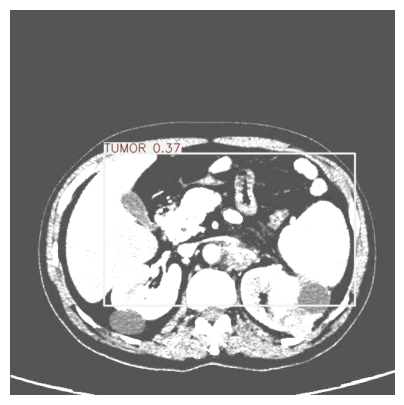

In [8]:
results = model.predict(source=get_img('Kidney-Disease-Detection-3/test/images/Tumor-1164-_jpg.rf.f94ba9ccc1f76086ef2beb35879c782f.jpg'),save=True)

# Get annotated image
img = results[0].plot()

# Display inline
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show()


0: 640x640 1 STONE, 287.2ms
Speed: 10.2ms preprocess, 287.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\ramka\datascience-nlp\34-kidneyProject\runs\detect\predict


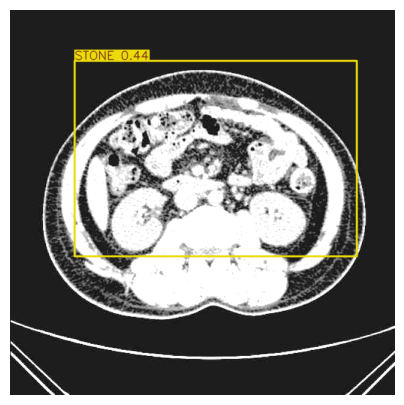

In [9]:
results = model.predict(source=get_img('./Kidney-Disease-Detection-3/test/images/Stone-1002-_jpg.rf.47549c7fb437e028328837f44e52380b.jpg'),save=True)

# Get annotated image
img = results[0].plot()

# Display inline
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show()

0: 640x640 1 NORMAL, 306.9ms
Speed: 7.9ms preprocess, 306.9ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\ramka\datascience-nlp\34-kidneyProject\runs\detect\predict


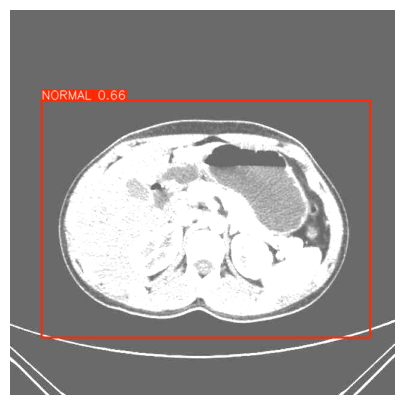

In [10]:
results = model.predict(source=get_img('./Kidney-Disease-Detection-3/test/images/Normal-1092-_jpg.rf.7dbe96b32240c8c2156ca2080b64bb44.jpg'),save=True)
# Get annotated image
img = results[0].plot()

# Display inline
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show()

In [12]:

import os
test_dir = './Kidney-Disease-Detection-3/test/images'

correct = 0
total = 0

# Get all image paths in directory
image_paths = [os.path.join(test_dir, f)
               for f in os.listdir(test_dir)
               if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for img_path in image_paths:

    # Preprocess image
    img = get_img(img_path)

    # Run prediction
    results = model.predict(source=img, save=False, verbose=False)

    # Predictions for *this* image
    preds = results[0].boxes.cls.cpu().numpy().tolist()

    # Get corresponding label file
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            actual_labels = [int(line.split()[0]) for line in f.readlines()]

        # Compare ground truth vs predictions
        if preds == actual_labels:
            correct += 1

    total += 1

print(f"Correct: {correct}/{total}")
print(f"Accuracy: {correct/total:.2f}")




Correct: 228/319
Accuracy: 0.71


In [13]:
print(results[0])

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'NORMAL', 1: 'STONE', 2: 'TUMOR', 3: 'cysts'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], s